# **NYC Restaurant Inspections Viz**

Joe Lardie

September 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder

#Scipy
from scipy import stats
from scipy.stats import norm

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

# **Data Dictionary**
**DBA**	This field represents the name (doing business as) of the entity (restaurant); Public business name, may change at discretion of restaurant owner

**BORO**	Borough in which the entity (restaurant) is located.;• 1 = MANHATTAN • 2 = BRONX • 3 = BROOKLYN • 4 = QUEENS • 5 = STATEN ISLAND • Missing; NOTE: There may be discrepancies between zip code and listed boro due to differences in an establishment's mailing address and physical location

**BUILDING**  Building number for establishment (restaurant) location

**STREET**	Street name for establishment (restaurant) location

**ZIPCODE**	Zip code of establishment (restaurant) location

**PHONE**	Phone Number; Phone number provided by restaurant owner/manager

**CUISINE DESCRIPTION**	This field describes the entity (restaurant) cuisine. ; Optional field provided by provided by restaurant owner/manager

**INSPECTION DATE**	This field represents the date of inspection; NOTE: Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection

**ACTION**	This field represents the actions that is associated with each restaurant inspection. ; • Violations were cited in the following area(s). • No violations were recorded at the time of this inspection. • Establishment re-opened by DOHMH • Establishment re-closed by DOHMH • Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed. • "Missing" = not yet inspected;

**VIOLATION CODE**	Violation code associated with an establishment (restaurant) inspection

**VIOLATION DESCRIPTION**Violation description associated with an establishment (restaurant) inspection

**CRITICAL FLAG**	Indicator of critical violation; "• Critical • Not Critical • Not Applicable"; Critical violations are those most likely to contribute to food-borne illness

**SCORE**Total score for a particular inspection; Scores are updated based on adjudication results

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

**GRADE DATE**	The date when the current grade was issued to the entity (restaurant)

**RECORD DATE**	The date when the extract was run to produce this data set

**INSPECTION TYPE** A combination of the inspection program and the type of inspection performed; See Data Dictionary for full list of expected values


## **Important Context**

RECORD DATE = (date of the data pull).

Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.

Establishments are uniquely identified by their CAMIS (record ID) number.

# **Import Data**

In [2]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [3]:
# Glance of inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210611 entries, 0 to 210610
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  210611 non-null  int64  
 1   DBA                    209970 non-null  object 
 2   BORO                   210611 non-null  object 
 3   BUILDING               210308 non-null  object 
 4   STREET                 210607 non-null  object 
 5   ZIPCODE                207890 non-null  float64
 6   CUISINE DESCRIPTION    208186 non-null  object 
 7   INSPECTION DATE        210611 non-null  object 
 8   ACTION                 208186 non-null  object 
 9   VIOLATION CODE         207055 non-null  object 
 10  VIOLATION DESCRIPTION  207055 non-null  object 
 11  CRITICAL FLAG          210611 non-null  object 
 12  SCORE                  200542 non-null  float64
 13  GRADE                  103135 non-null  object 
 14  GRADE DATE             94324 non-nul

- Grade date has the fewest amount of values

# **Data Cleaning**

### **Function to clean up names**

In [4]:
# Function to clean restaurant names
def clean_restaurant_name(name):
    # Check if the input is a string
    if isinstance(name, str):
        # Remove store numbers using regular expression
        cleaned_name = re.sub(r'#\d+', '', name)
        
        # Remove all numeric characters
        cleaned_name = re.sub(r'\d+', '', cleaned_name)
    
        # Remove leading and trailing whitespace
        cleaned_name = cleaned_name.strip()
    
        return cleaned_name
    else:
        return name  # Return the input unchanged for non-string values

# Apply the clean_restaurant_name function to the 'DBA' column
rdf['Cleaned Restaurant Name'] = rdf['DBA'].apply(clean_restaurant_name)

In [5]:
rdf['ZIPCODE'].value_counts()

10013.0    4748
10003.0    4747
10019.0    4173
10036.0    4048
10002.0    4029
           ... 
11003.0       1
11518.0       1
8512.0        1
10704.0       1
11550.0       1
Name: ZIPCODE, Length: 226, dtype: int64

In [6]:
rdf['DBA'].value_counts()

DUNKIN                      2610
SUBWAY                      1553
STARBUCKS                   1212
MCDONALD'S                  1049
KENNEDY FRIED CHICKEN        711
                            ... 
Rinconsito Restaurant          1
IDENTITY                       1
LEGACY BAR & GRILL             1
E.B. FLAVOR TERMINAL INC       1
THE LEGEND'S LOUNGE            1
Name: DBA, Length: 22195, dtype: int64

In [7]:
# checking missing data in data 
def check_missing_data(rdf):
    total = rdf.isnull().sum().sort_values(ascending = False)
    percent = (rdf.isnull().sum()/rdf.isnull().count()*100).sort_values(ascending = False)
    percent = percent.round(2).astype(str) + '%'
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(rdf)
missing_data_result.head()

,Total,Percent
GRADE DATE,116287,55.21%
GRADE,107476,51.03%
SCORE,10069,4.78%
VIOLATION DESCRIPTION,3556,1.69%
VIOLATION CODE,3556,1.69%


Grade, Score, and Grade date - missing a lot of data due to some places not yet receiving an inspection
DBA needs to reference CAMIS to ensure the situation surrounding the repeated rows
Inspection Type may be related to places not yet received an inspection


In [8]:
# Checking for duplicates
rdf.duplicated().sum()

6

In [9]:
rdf['SCORE'].describe()

count    200542.000000
mean         22.902080
std          17.596283
min           0.000000
25%          11.000000
50%          19.000000
75%          31.000000
max         168.000000
Name: SCORE, dtype: float64

In [10]:
rdf['CAMIS'].value_counts()

40398688    65
41406895    59
50045647    56
40365904    52
50123073    51
            ..
50114437     1
50143155     1
50113637     1
50121058     1
50089033     1
Name: CAMIS, Length: 28475, dtype: int64

In [11]:
rdf['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          114067
Cycle Inspection / Re-inspection                                37193
Pre-permit (Operational) / Initial Inspection                   31594
Pre-permit (Operational) / Re-inspection                         9658
Administrative Miscellaneous / Initial Inspection                5047
Pre-permit (Non-operational) / Initial Inspection                2662
Pre-permit (Operational) / Compliance Inspection                 1633
Cycle Inspection / Reopening Inspection                          1408
Administrative Miscellaneous / Re-inspection                      990
Cycle Inspection / Compliance Inspection                          808
Pre-permit (Operational) / Reopening Inspection                   740
Smoke-Free Air Act / Initial Inspection                           554
Trans Fat / Initial Inspection                                    388
Calorie Posting / Initial Inspection                              335
Inter-Agency Task Fo

In [12]:
# Looking at different Restaurant Types, Potential to filter out specific types for geospacial analysis
all_unique_values = rdf['CUISINE DESCRIPTION'].unique()
print(all_unique_values)

[nan 'Korean' 'Thai' 'American' 'Middle Eastern'
 'Bakery Products/Desserts' 'Spanish' 'Pizza' 'Scandinavian'
 'Bottled Beverages' 'Greek' 'Chicken' 'Seafood' 'Coffee/Tea' 'Japanese'
 'Hotdogs/Pretzels' 'Lebanese' 'Mediterranean' 'Hamburgers'
 'Latin American' 'Italian' 'African' 'Chinese' 'Caribbean' 'Tex-Mex'
 'Soups' 'French' 'Sandwiches' 'Vegetarian'
 'Juice, Smoothies, Fruit Salads' 'Peruvian' 'Indian' 'Continental'
 'Turkish' 'Donuts' 'Brazilian' 'Jewish/Kosher' 'Mexican'
 'Asian/Asian Fusion' 'Russian' 'Bangladeshi' 'Other' 'Eastern European'
 'Filipino' 'Irish' 'Steakhouse' 'Frozen Desserts'
 'Sandwiches/Salads/Mixed Buffet' 'Hotdogs' 'Salads' 'Bagels/Pretzels'
 'Vegan' 'Hawaiian' 'Soul Food' 'Tapas' 'Barbecue' 'Moroccan' 'Creole'
 'Chinese/Japanese' 'Southeast Asian' 'Californian' 'New American'
 'Soups/Salads/Sandwiches' 'Pancakes/Waffles' 'Afghan' 'Polish' 'English'
 'Fusion' 'Not Listed/Not Applicable' 'Australian' 'Ethiopian'
 'Portuguese' 'Indonesian' 'New French' 'Pakist

## **Grade Date by Year**

In [13]:
# Convert the 'GRADE DATE' column to datetime type
rdf['GRADE DATE'] = pd.to_datetime(rdf['GRADE DATE'])

# Filter rows for the year 2016
desired_year = 2016 
filtered_df = rdf[rdf['GRADE DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 370 to 209118
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    266 non-null    int64         
 1   DBA                      266 non-null    object        
 2   BORO                     266 non-null    object        
 3   BUILDING                 259 non-null    object        
 4   STREET                   266 non-null    object        
 5   ZIPCODE                  203 non-null    float64       
 6   CUISINE DESCRIPTION      266 non-null    object        
 7   INSPECTION DATE          266 non-null    object        
 8   ACTION                   266 non-null    object        
 9   VIOLATION CODE           229 non-null    object        
 10  VIOLATION DESCRIPTION    229 non-null    object        
 11  CRITICAL FLAG            266 non-null    object        
 12  SCORE                    266 no

2016 = 293

2017 = 934

2018 = 1358

2019 = 6832

2020 = 5339

2021 = 7878

2022 = 38820

2023 = 30296

## **Inspection Date by Year**

2016 = 483

2017 = 1578

2018 = 2340

2019 = 13033

2020 = 10562

2021 = 20800

2022 = 88263

2023 = 65539

In [14]:
# Convert the 'GRADE DATE' column to datetime type
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'])

# Filter rows for the year
desired_year = 2023
filtered_df = rdf[rdf['INSPECTION DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82369 entries, 34 to 210605
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    82369 non-null  int64         
 1   DBA                      82369 non-null  object        
 2   BORO                     82369 non-null  object        
 3   BUILDING                 82305 non-null  object        
 4   STREET                   82369 non-null  object        
 5   ZIPCODE                  81530 non-null  float64       
 6   CUISINE DESCRIPTION      82369 non-null  object        
 7   INSPECTION DATE          82369 non-null  datetime64[ns]
 8   ACTION                   82369 non-null  object        
 9   VIOLATION CODE           81941 non-null  object        
 10  VIOLATION DESCRIPTION    81941 non-null  object        
 11  CRITICAL FLAG            82369 non-null  object        
 12  SCORE                    78539

# **Visualizations**

# **Scores**

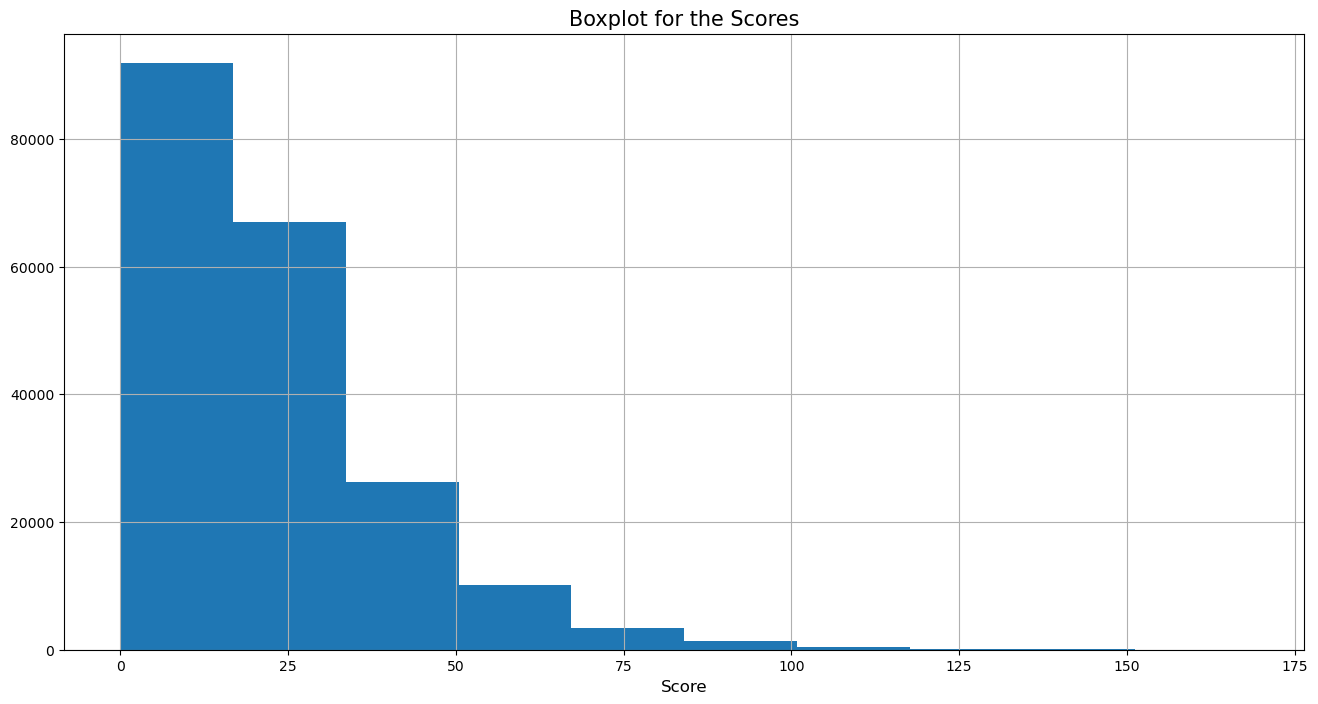

In [15]:
# Plot a histogram
rdf.SCORE.hist(figsize=(16,8))
plt.title("Boxplot for the Scores", fontsize=15)
plt.xlabel('Score', fontsize = 12);

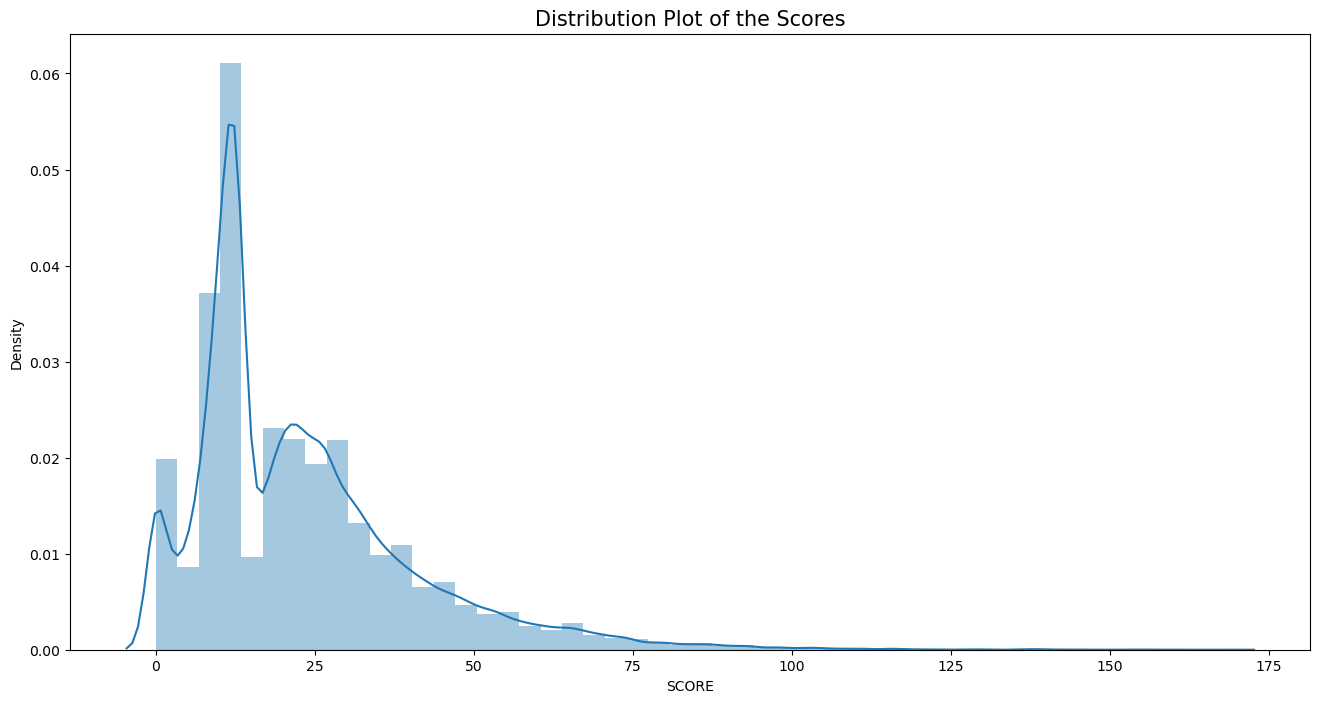

In [16]:
# Have a look at a distribution plot of the Score
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
sns.distplot(rdf.SCORE.dropna())
plt.title("Distribution Plot of the Scores", fontsize=15);

## **NYC Boros**

### **Important Context:**

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

In [17]:
# Filter rows where 'BORO' is 0
f_df = rdf[rdf['BORO'] != '0']

# Display the filtered DataFrame
print(f_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210601 entries, 0 to 210610
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CAMIS                    210601 non-null  int64         
 1   DBA                      209968 non-null  object        
 2   BORO                     210601 non-null  object        
 3   BUILDING                 210302 non-null  object        
 4   STREET                   210601 non-null  object        
 5   ZIPCODE                  207884 non-null  float64       
 6   CUISINE DESCRIPTION      208186 non-null  object        
 7   INSPECTION DATE          210601 non-null  datetime64[ns]
 8   ACTION                   208186 non-null  object        
 9   VIOLATION CODE           207055 non-null  object        
 10  VIOLATION DESCRIPTION    207055 non-null  object        
 11  CRITICAL FLAG            210601 non-null  object        
 12  SCORE           

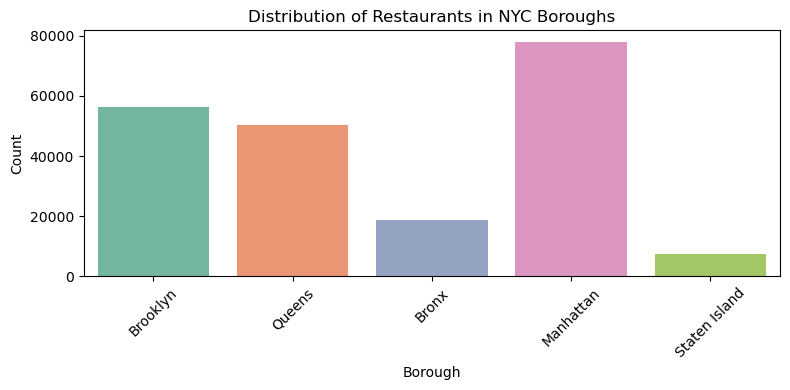

In [39]:
# Visualizing Distribution of Restaurants in NYC Boroughs
plt.figure(figsize=(8, 4))
sns.countplot(data=f_df, x='BORO', palette='Set2') 
plt.title('Distribution of Restaurants in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

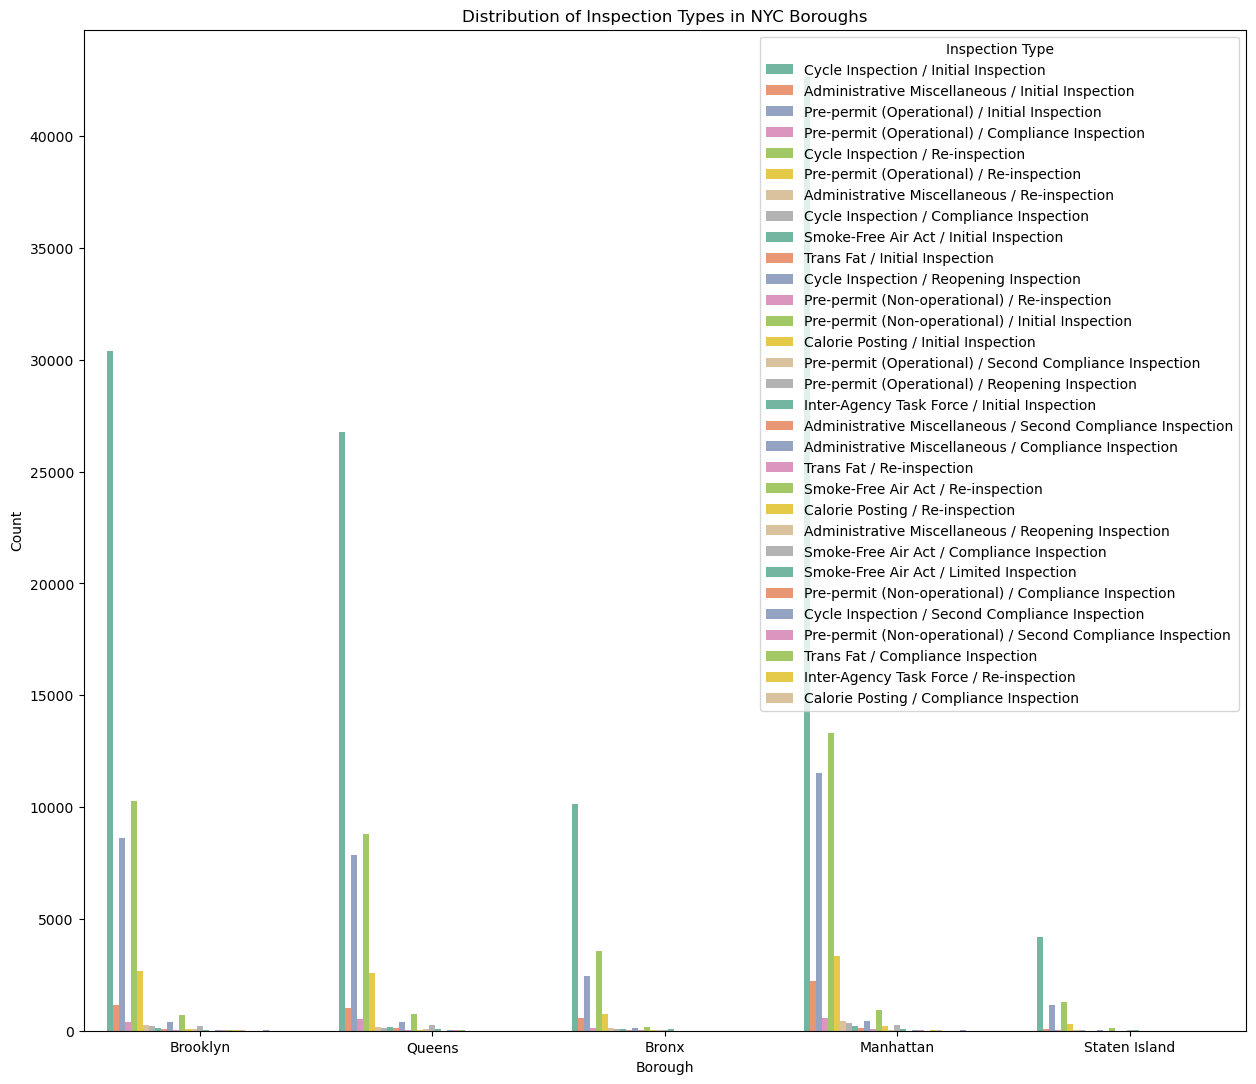

In [19]:
# Create a stacked bar chart using Seaborn
plt.figure(figsize=(15,13))
sns.countplot(x='BORO', hue='INSPECTION TYPE', data=f_df, palette='Set2')
plt.title('Distribution of Inspection Types in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
# Show the plot
plt.legend(title='Inspection Type', bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

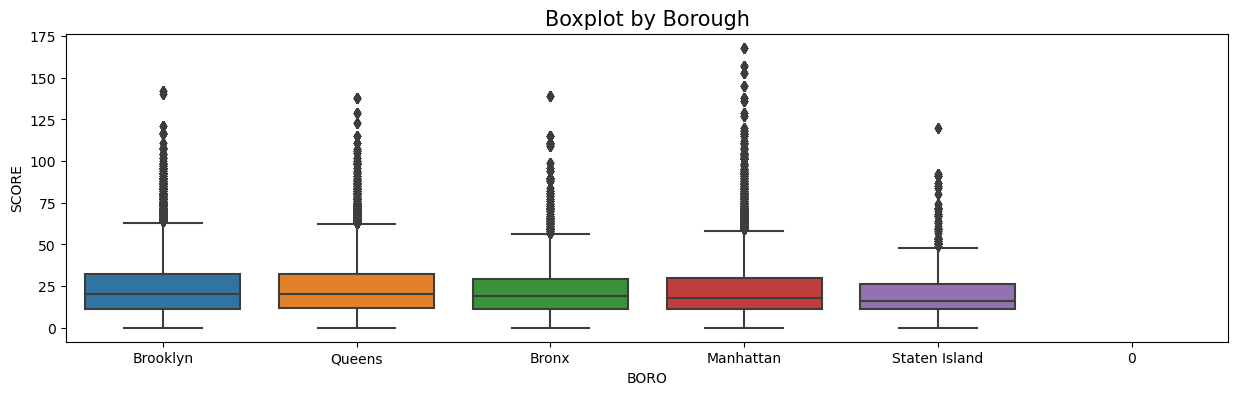

In [20]:
# Create a boxplot using Seaborn
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='BORO', y='SCORE', data=rdf)
plt.title('Boxplot by Borough', fontsize=15)

# Show the plot
plt.show()

## **Grade**

In [21]:
# Contingency table for Grade and Borough
boro_grade = pd.crosstab(rdf.GRADE, rdf.BORO, margins = True)
boro_grade

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island,All
GRADE,,,,,,
A,6033,18497,27131,16779,2962,71402
B,1175,3104,3965,2934,410,11588
C,564,1906,2416,1885,155,6926
N,740,1962,3463,2352,315,8832
P,44,170,208,137,13,572
Z,474,985,1234,1013,109,3815
All,9030,26624,38417,25100,3964,103135


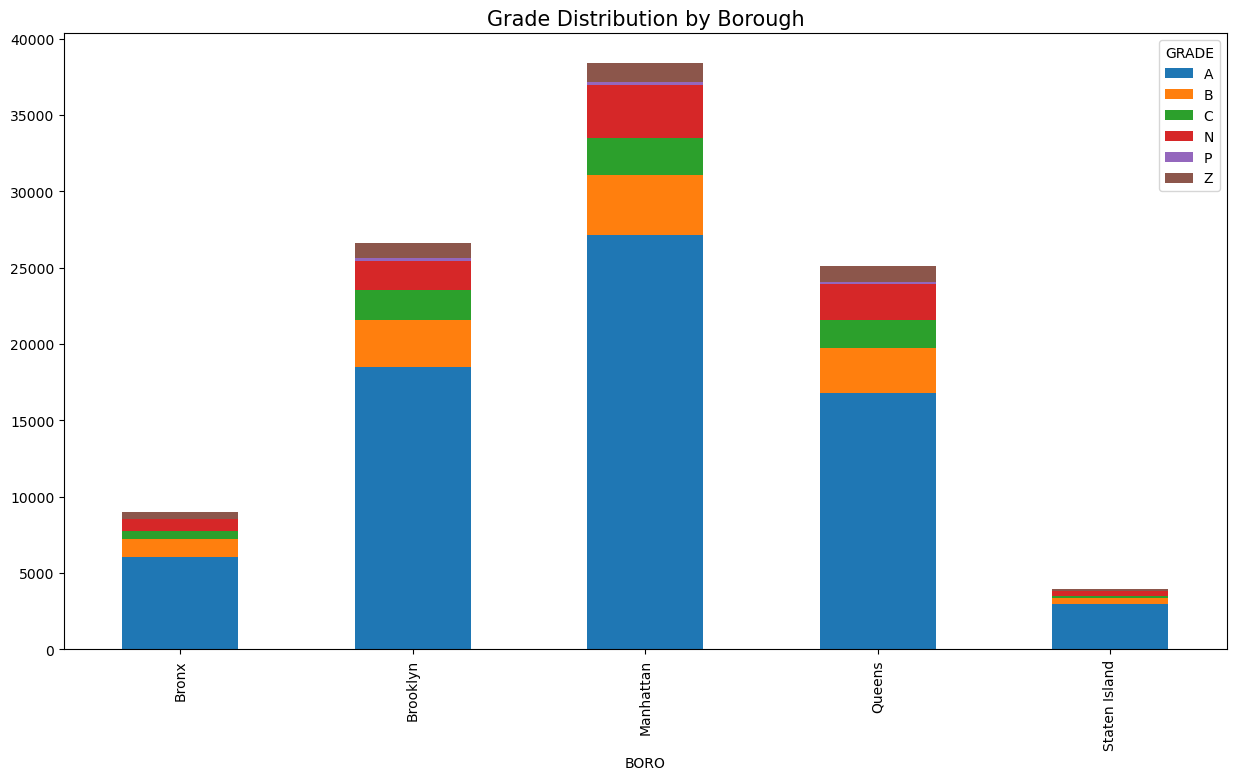

In [22]:
# Plot of grade by borough
pd.crosstab(rdf.BORO, rdf.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);

In [23]:
# Test if the grades are independent of the borough
boro_grade.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND" ,"All"]

boro_grade.index = ["A","B","C","Not Yet Graded","P", "Z", "All"]

observed = boro_grade.iloc[0:6,0:5]   # Get table without totals for later use

expected =  np.outer(boro_grade["All"][0:6],
                     boro_grade.loc["All"][0:5]) / 1000

expected = pd.DataFrame(expected)

expected.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND"]
expected.index = ["A","B","C","Not Yet Graded","P", "Z"]

chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print("Chi Squared Stat")
print(chi_squared_stat)

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 20)   # (5-1) * (6-1)

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=20)
print("P value")
print(p_value)

stats.chi2_contingency(observed= observed)

Chi Squared Stat
10431562.080278533
Critical value
31.410432844230918
P value
0.0


(397.6141513150395,
 6.387335324877355e-72,
 20,
 array([[6.25161255e+03, 1.84322184e+04, 2.65966998e+04, 1.73771290e+04,
         2.74434021e+03],
        [1.01458903e+03, 2.99140846e+03, 4.31644152e+03, 2.82017550e+03,
         4.45385485e+02],
        [6.06406942e+02, 1.78792674e+03, 2.57988212e+03, 1.68558297e+03,
         2.66201231e+02],
        [7.73287051e+02, 2.27995509e+03, 3.28985256e+03, 2.14944684e+03,
         3.39458457e+02],
        [5.00815436e+01, 1.47660135e+02, 2.13065632e+02, 1.39207834e+02,
         2.19848548e+01],
        [3.34022883e+02, 9.84831144e+02, 1.42105837e+03, 9.28457847e+02,
         1.46629757e+02]]))

## **Distribution of Grades**

Text(0.5, 1.0, 'Boxplot by Grade')

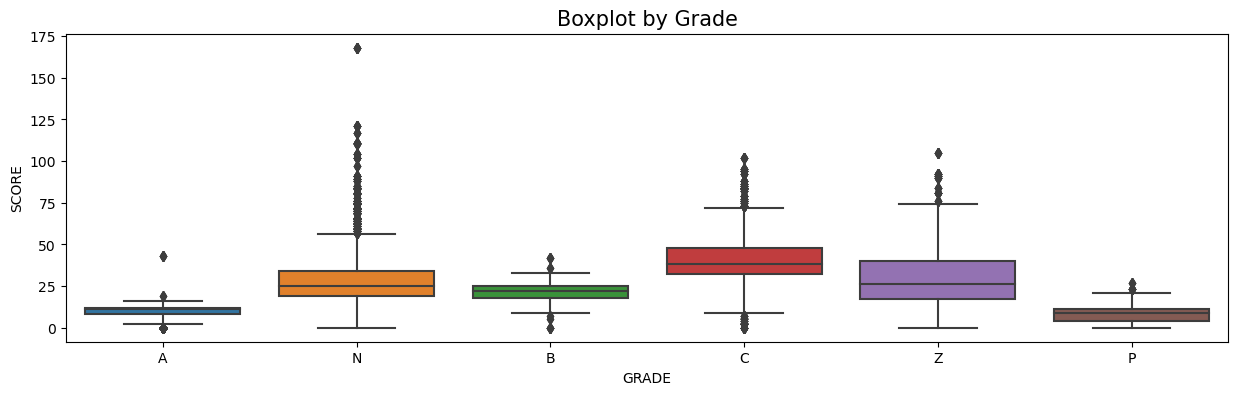

In [24]:
# Lets look at scores by grades with a Boxplot
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='GRADE', y='SCORE', data=rdf)
plt.title('Boxplot by Grade', fontsize = 15)

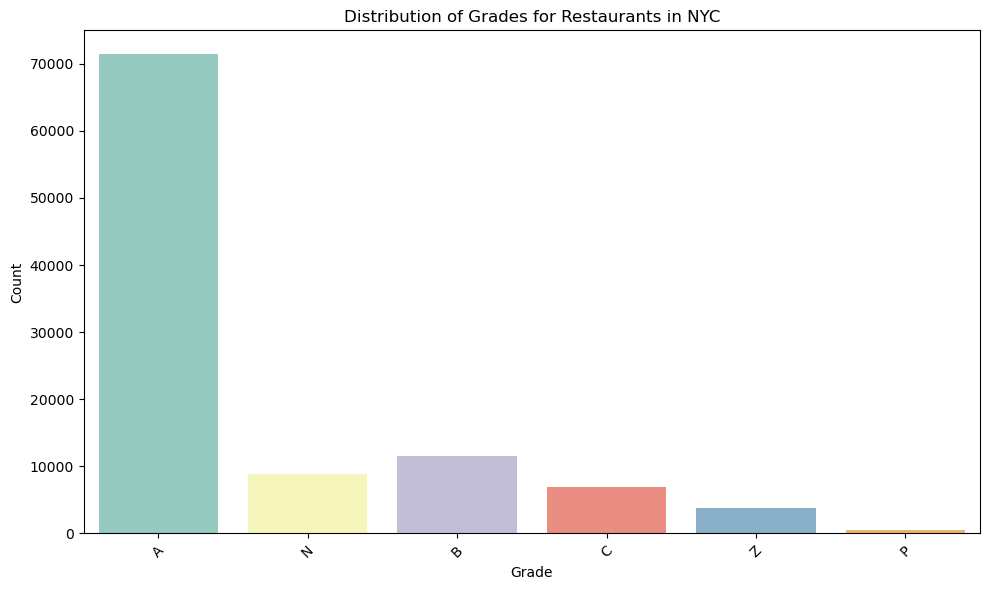

In [25]:
# Visualizing Distribution of Grades for Restaurants in NYC
plt.figure(figsize=(10, 6))
sns.countplot(data=rdf, x='GRADE', palette='Set3')  
plt.title('Distribution of Grades for Restaurants in NYC')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

## **Distribution of Cuisine Types**

In [26]:
# Filteriung out the irrelevant Cuisine Types for Visalization
min_cuisine_count = 1000
cuisine_counts = rdf['CUISINE DESCRIPTION'].value_counts()
filtered_cuisines = cuisine_counts[cuisine_counts >= min_cuisine_count].index
fdf = rdf[rdf['CUISINE DESCRIPTION'].isin(filtered_cuisines)]

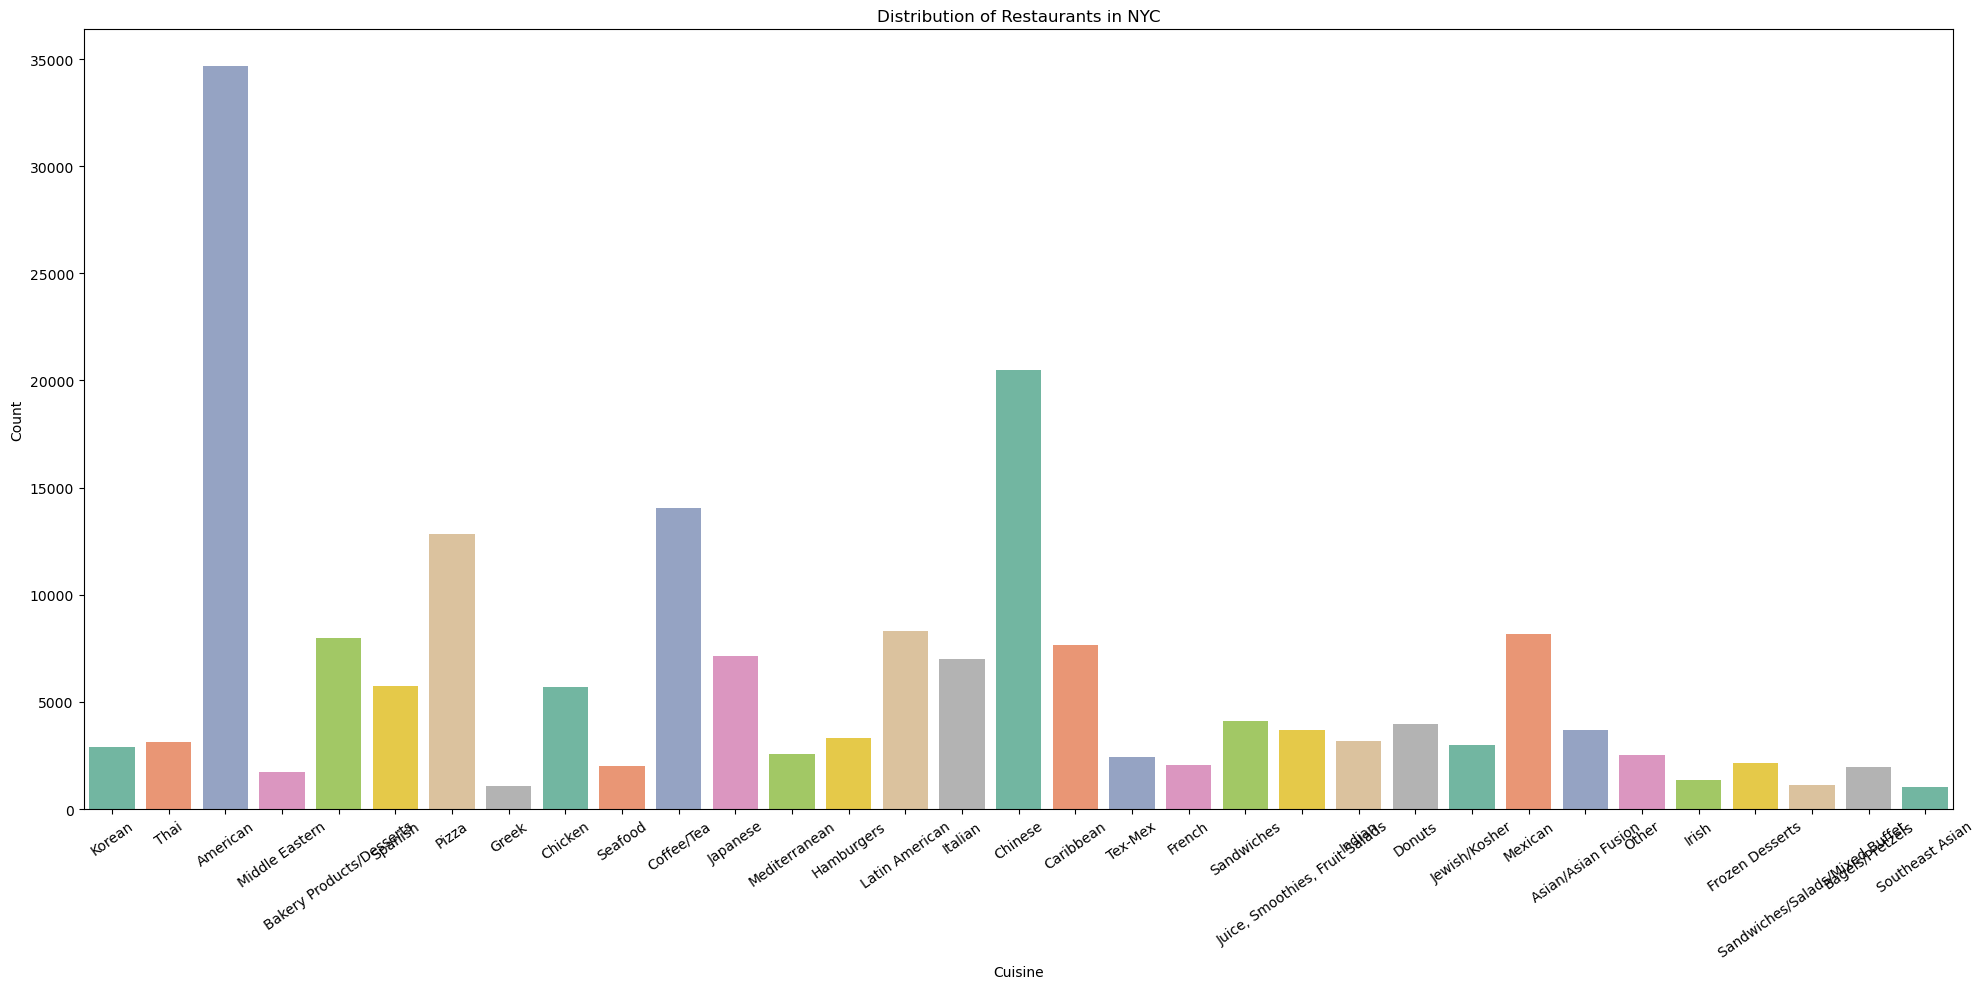

In [27]:
# Visualization of most popular cuisines
plt.figure(figsize=(20,10))
sns.countplot(data=fdf, x='CUISINE DESCRIPTION', palette='Set2') 
plt.title('Distribution of Restaurants in NYC')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=35) 

plt.tight_layout()
plt.show()

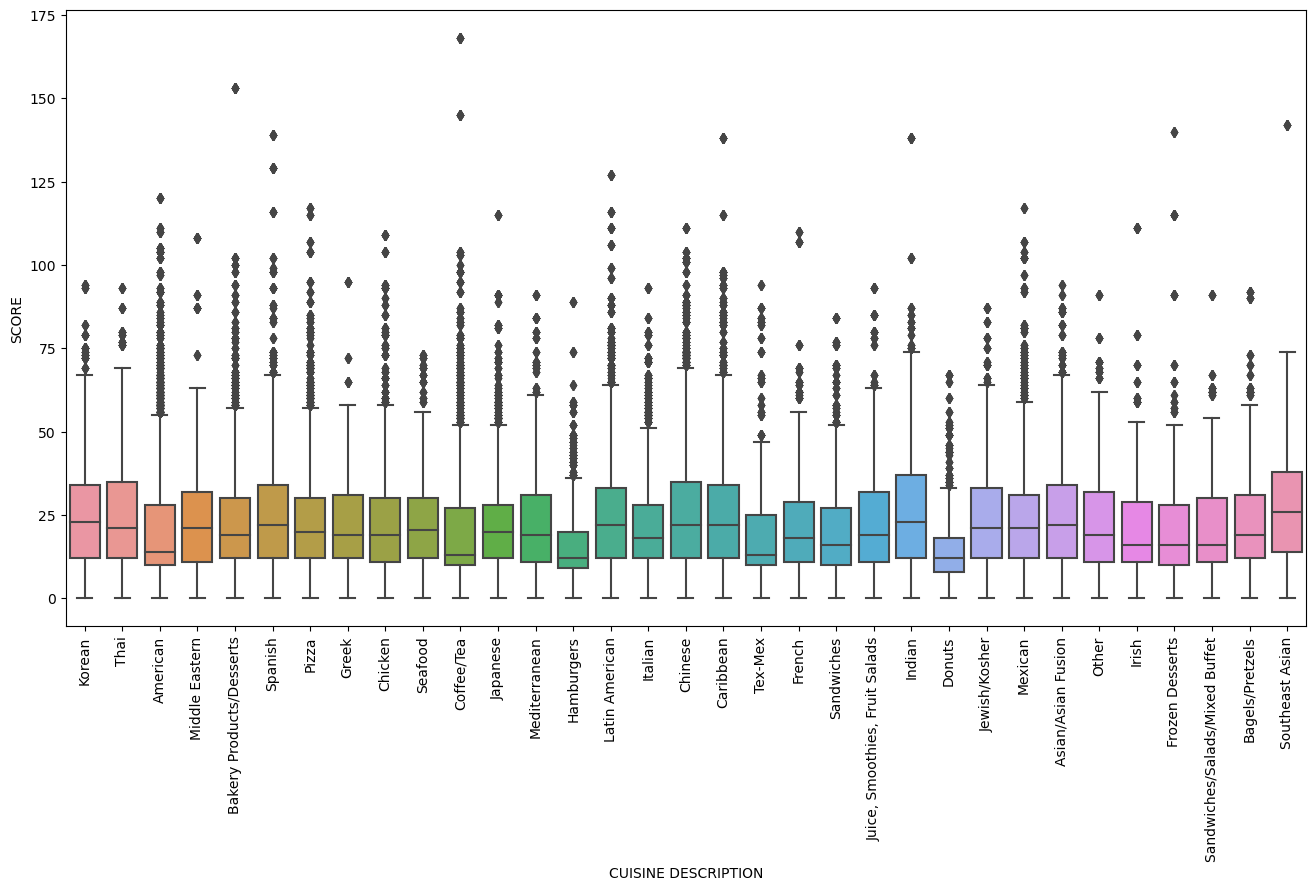

In [28]:
# Let us look at the scores by cuisine
score_cuisine = pd.concat([fdf['CUISINE DESCRIPTION'], fdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE DESCRIPTION', y="SCORE", data = fdf)
plt.xticks(rotation=90);

# **Action Analysis**

In [29]:
rdf.ACTION.value_counts()

Violations were cited in the following area(s).                                                                                       197256
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      7893
Establishment re-opened by DOHMH.                                                                                                       1877
No violations were recorded at the time of this inspection.                                                                             1156
Establishment re-closed by DOHMH.                                                                                                          4
Name: ACTION, dtype: int64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Violations were cited in the following area(s).'),
  Text(1, 0, 'No violations were recorded at the time of this inspection.'),
  Text(2, 0, 'Establishment re-opened by DOHMH.'),
  Text(3, 0, 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'),
  Text(4, 0, 'Establishment re-closed by DOHMH.')])

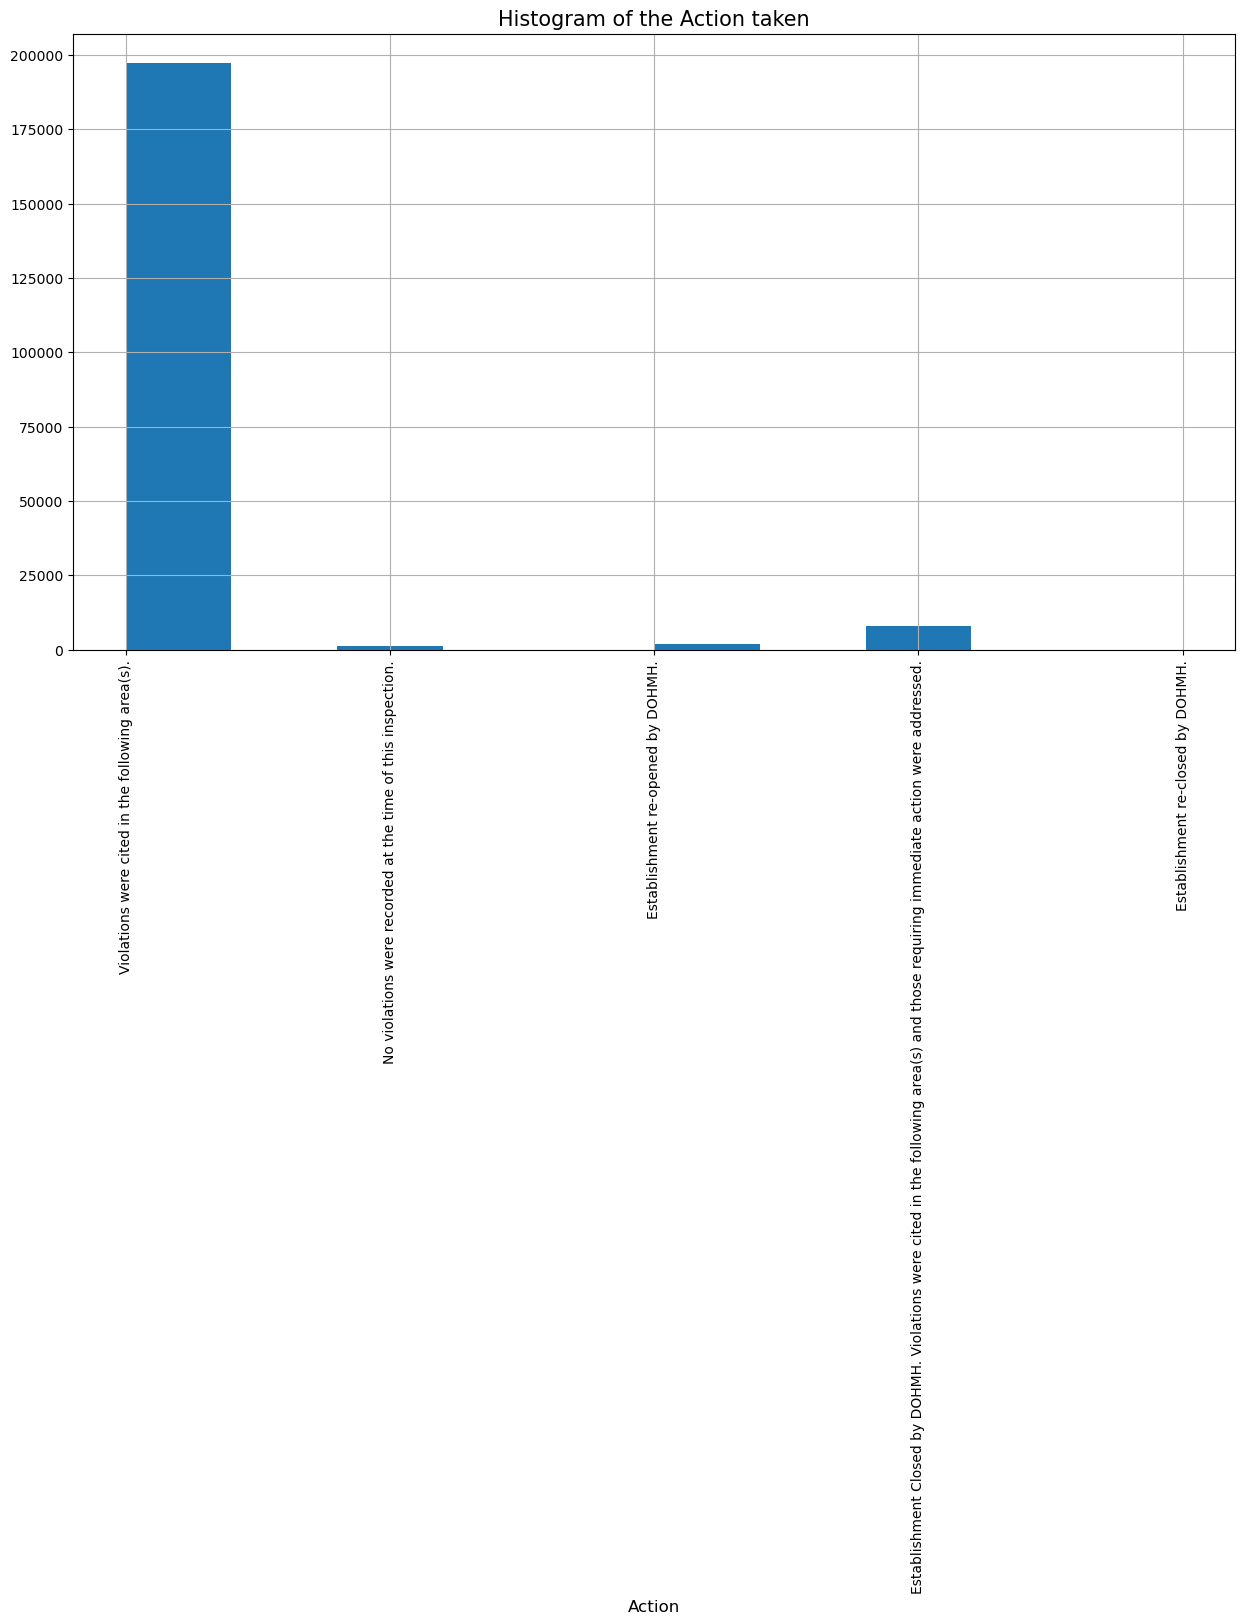

In [30]:
# Histogram of the Action taken
rdf.ACTION.hist(figsize = (15,8))
plt.title('Histogram of the Action taken', fontsize = 15)
plt.xlabel('Action', fontsize = 12)
plt.xticks(rotation=90)

In [31]:
rdf['CRITICAL FLAG'].value_counts()

Critical          114477
Not Critical       91270
Not Applicable      4864
Name: CRITICAL FLAG, dtype: int64

Text(0.5, 0, 'Flag')

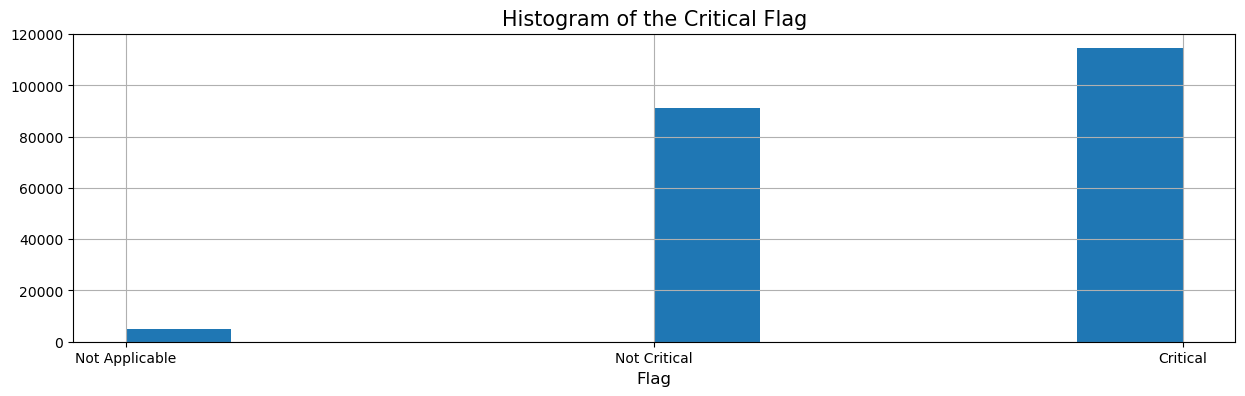

In [32]:
# Graphical representation of the critical flag
rdf['CRITICAL FLAG'].hist(figsize=(15,4))
plt.title('Histogram of the Critical Flag', fontsize = 15)
plt.xlabel('Flag', fontsize = 12)

Text(0.5, 1.0, 'Critical Flag by Borough')

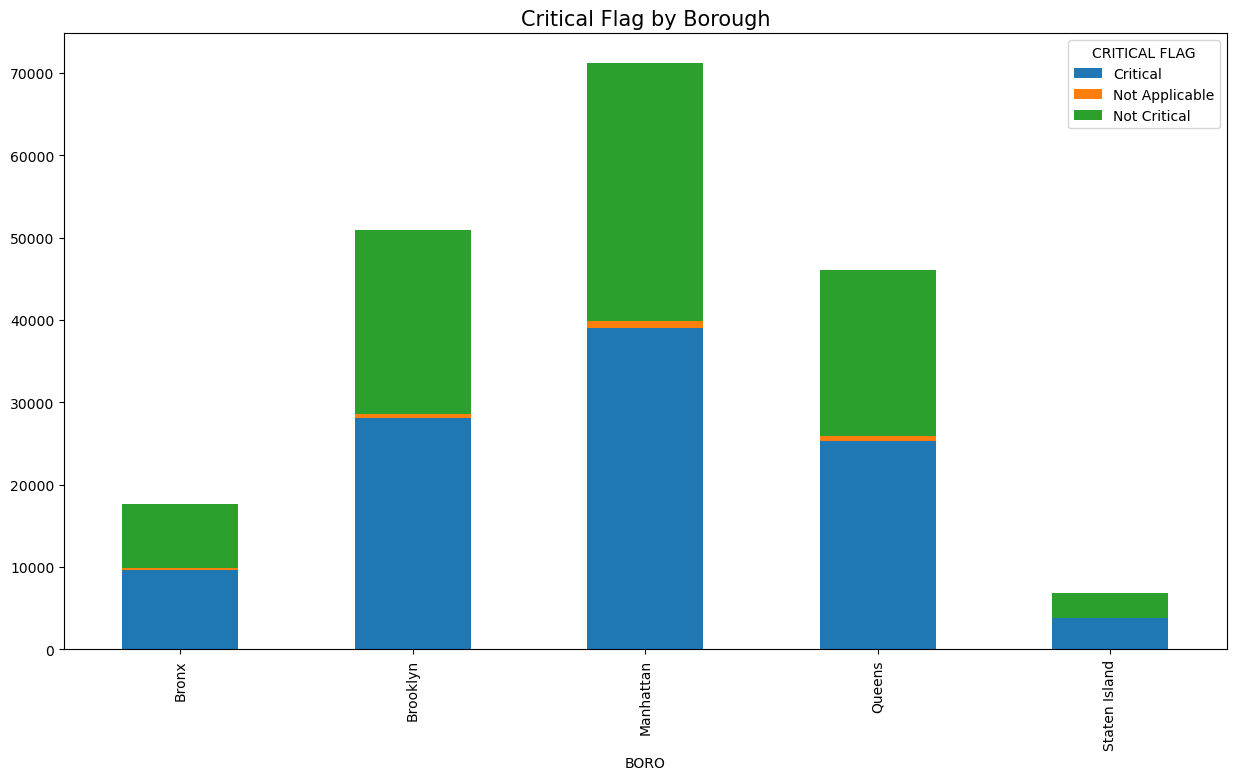

In [33]:
# Critical Flag by Borough
pd.crosstab(fdf.BORO, rdf['CRITICAL FLAG']).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Critical Flag by Borough', fontsize = 15)

Text(0.5, 1.0, 'Critical Flag by Cuisine')

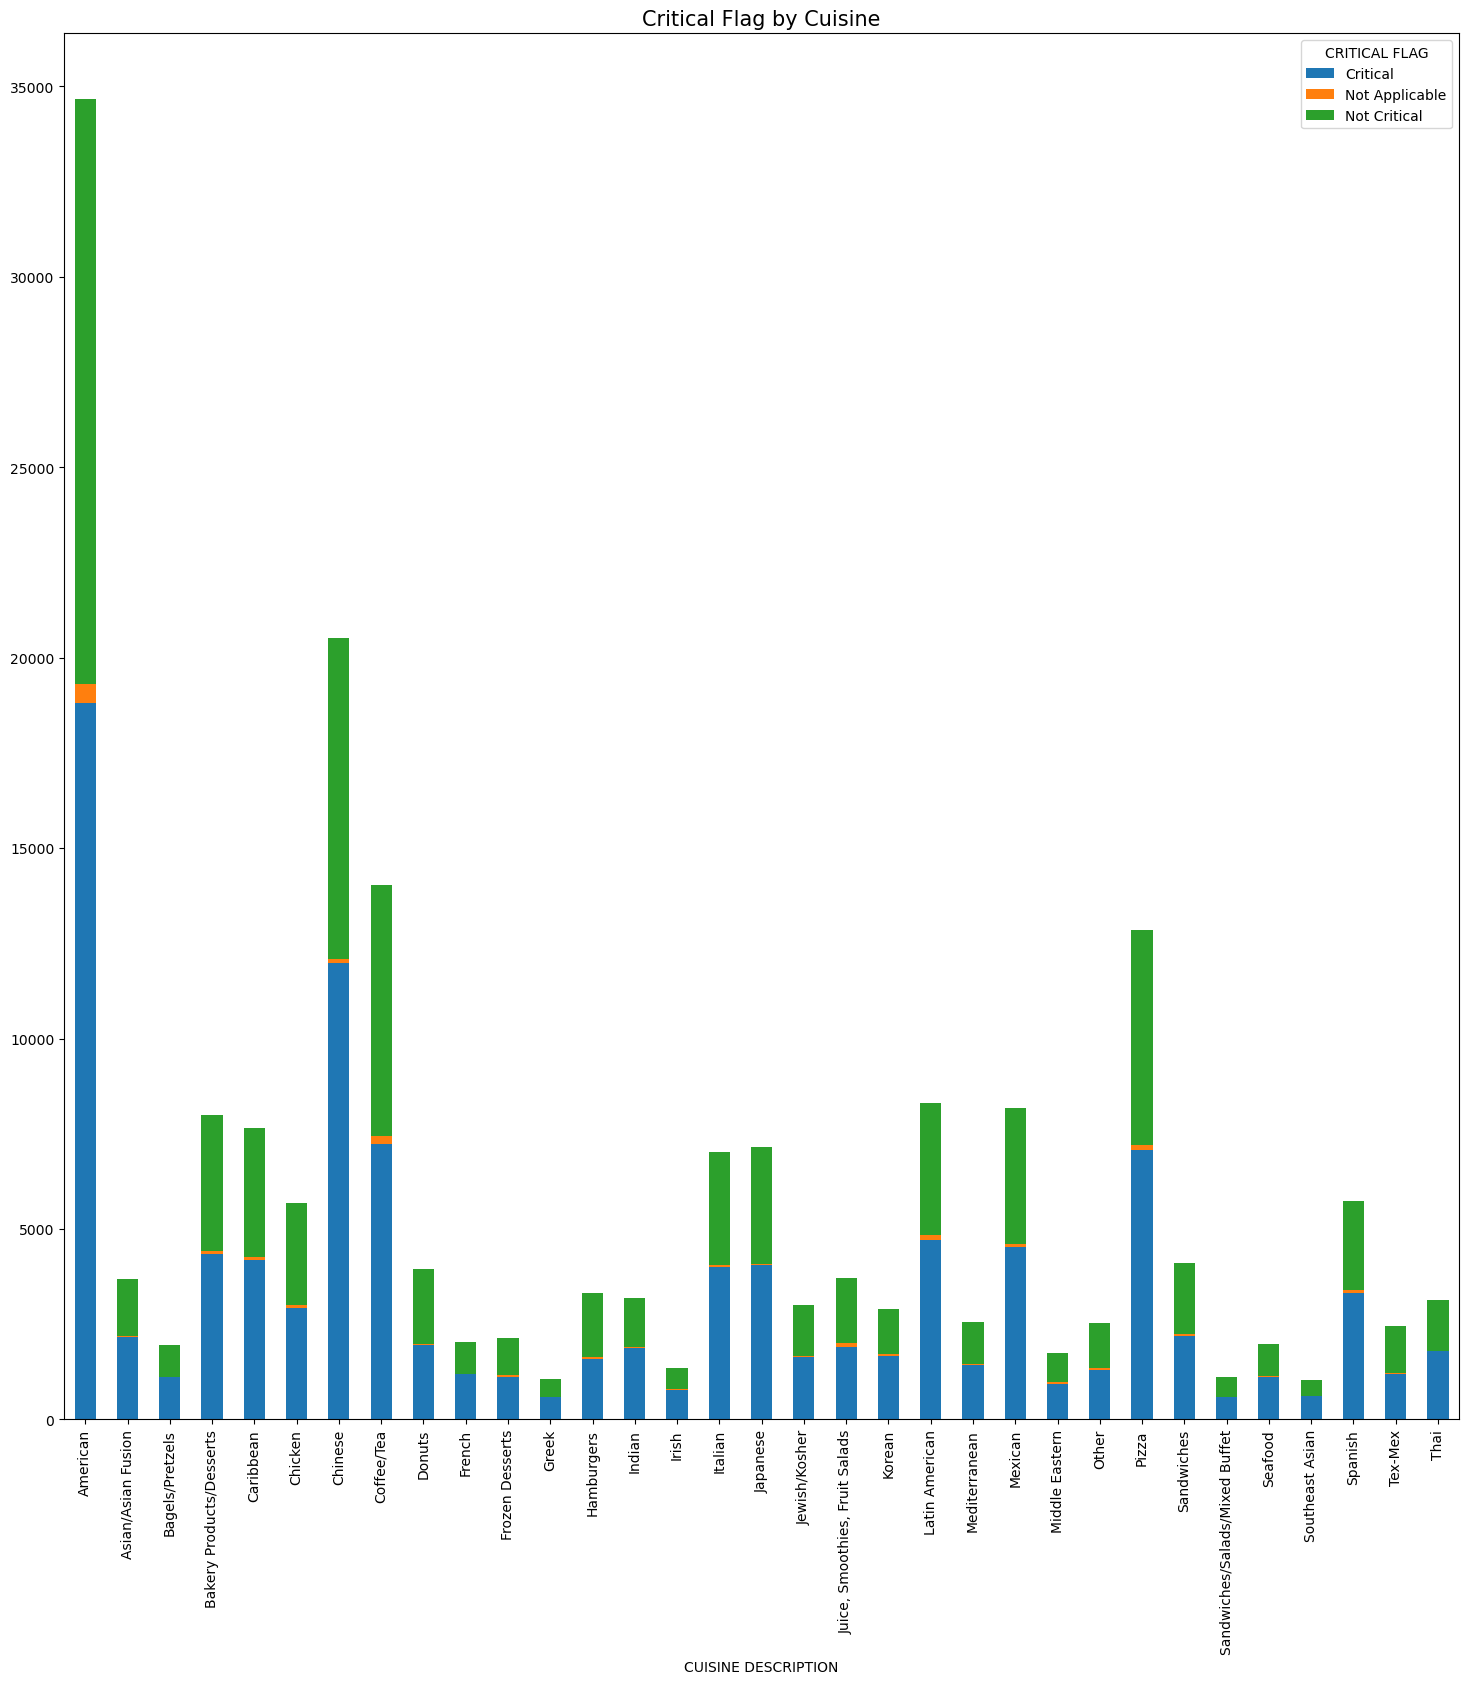

In [34]:
# Critical Flag by Cuisine
pd.crosstab(fdf['CUISINE DESCRIPTION'], fdf['CRITICAL FLAG']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15)

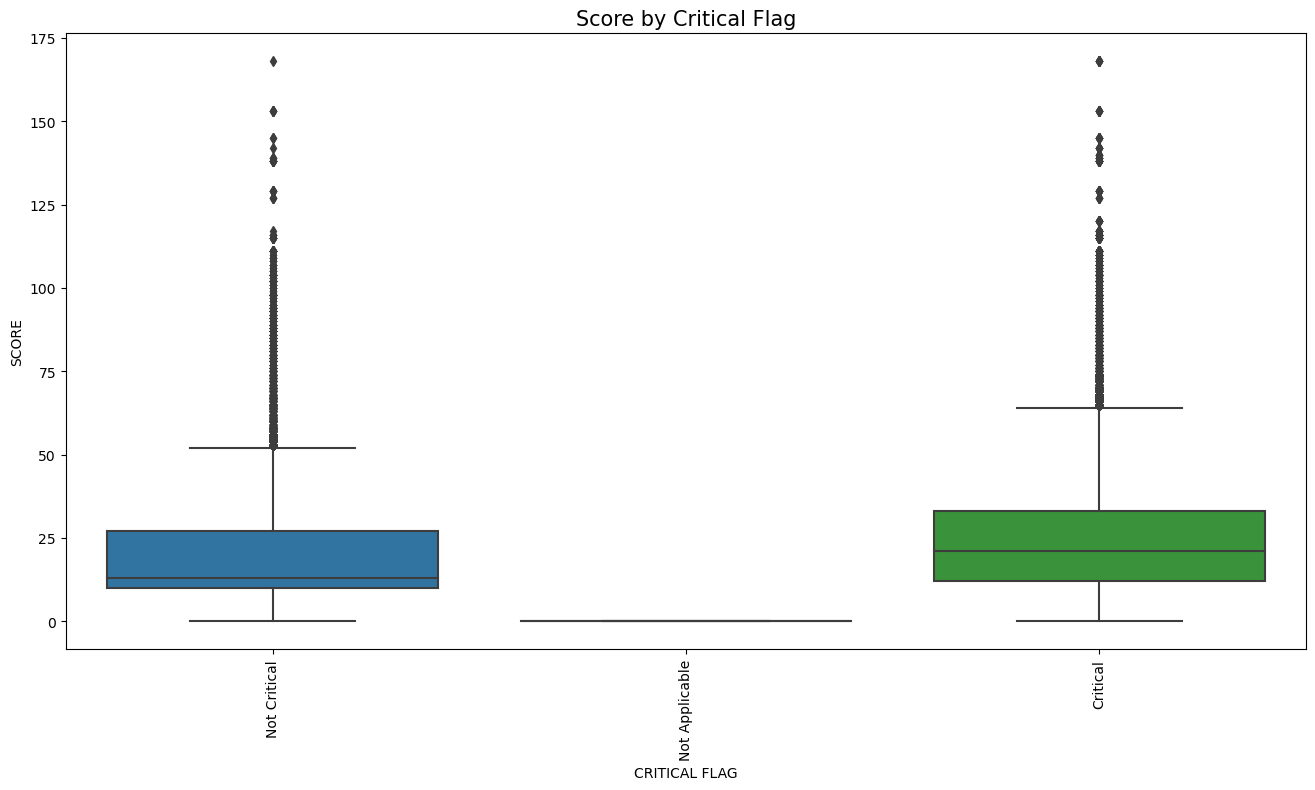

In [35]:
# Let us look at the scores by critical flag
score_flag = pd.concat([fdf['CRITICAL FLAG'], fdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CRITICAL FLAG', y="SCORE", data = score_flag)
plt.title('Score by Critical Flag', fontsize = 15)
plt.xticks(rotation=90);

# **Text Visual**

In [36]:
rdf['VIOLATION DESCRIPTION'].value_counts()

Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.                                                            16996
Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.                                                                                                                                     14100
Establishment is not free of harborage or conditions conducive to rodents, insects or other pests.                                                                                                                                                                                 13507
Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly 

In [37]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

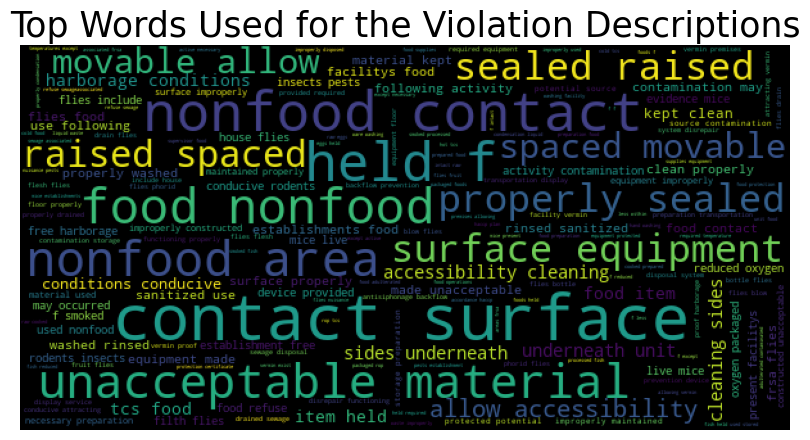

In [38]:
# Let us create a word cloud for the violation description
temp_data = rdf.dropna(subset=['VIOLATION DESCRIPTION'])
# converting into lowercase
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].map(text_prepare)
# Wordcloud visual for most used words for Violation Desriptions
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['VIOLATION DESCRIPTION'].values))
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.title("Top Words Used for the Violation Descriptions", fontsize=25)
plt.axis("off")
plt.show()